In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def calculate_Tn(n, cache):
    if n == 0:
        return np.array([1])
    if n == 1:
        return np.array([0,1])
    if n in cache:
        return cache[n]
    # T_(n+1)(X) = 2*X*T_n(X) - T_(n-1)(X)
    Tn_0 = calculate_Tn(n-1, cache)
    Tn_1 = calculate_Tn(n-2, cache)

    Tn = np.zeros((max(len(Tn_0)+1, len(Tn_1)),))
    for i in range(len(Tn_0)):
        Tn[i+1] += Tn_0[i]*2
    for i in range(len(Tn_1)):
        Tn[i] -= Tn_1[i]
    cache[n] = Tn
    return Tn

def plot_Tn(Tn_coeffs, x):
    y = np.zeros(x.shape)
    xn = np.ones(x.shape)
    for Tn_coeff in Tn_coeffs:
        if Tn_coeff != 0:
            y += Tn_coeff*xn
        xn *= x
    return y

def get_xn(x, n, cache):
    if n == 1:
        return x
    y = get_xn(x, n-1, cache)*x
    cache[n] = y
    return y

def calc_integral_n(n, x, xn_cache={}, In_cache={}):
    # In(x) = int x^n / sqrt(1-x^2) dx 
    # In(x) = 1/n * [ -x^(n-1) * sqrt(1-x^2) + (n-1) * I_(n-2)(x) ]
    if n == 0:
        return np.arcsin(x)
    x_2 = get_xn(x, 2, xn_cache)
    if n == 1:
        return -np.sqrt(1-x_2)
    if n in In_cache:
        return In_cache[n]
    x_n1 = get_xn(x, n-1, xn_cache)
    I_n2 = calc_integral_n(n-2, x, xn_cache=xn_cache, In_cache=In_cache)
    I_n = 1/n * (-x_n1*np.sqrt(1-x_2) + (n-1)*I_n2)
    In_cache[n] = I_n
    return I_n

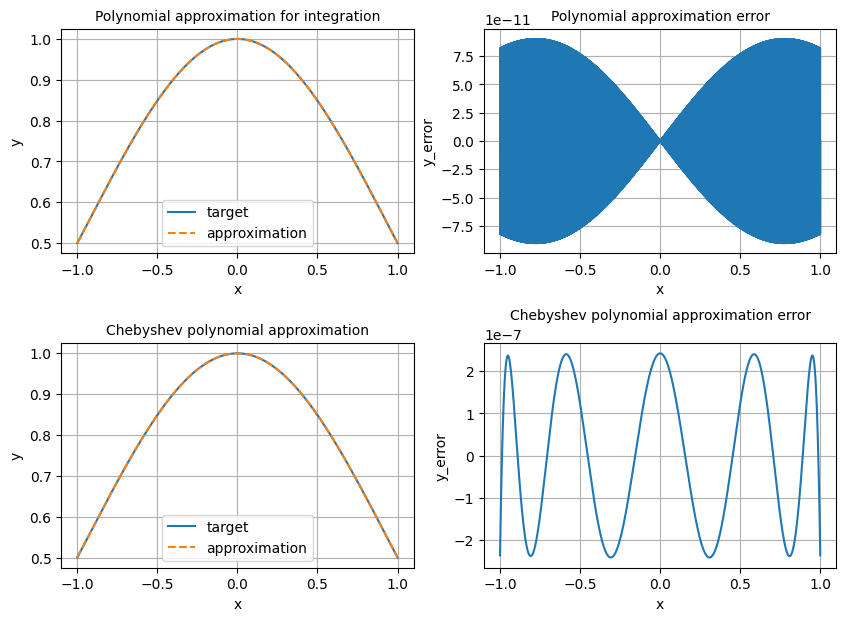

In [3]:
def f1_calculate_chebyshev_polynomial():
    #f_target = lambda x: np.cos(np.pi*x)
    #f_target = lambda x: np.sin(2*np.pi*x)
    #f_target = lambda x: np.exp(np.pi*x) * np.cos(8*np.pi*x)
    #f_target = lambda x: np.tan(x)
    def f_target(x):
        # lambda x: np.sin(np.pi*x) / [x*(x-1)*(x+1)]
        root = 1
        A0 = np.pi
        A1 = -A0/(root**2)
        B0 = np.sin(A0*x)
        B1 = np.copy(x)
        B3 = x-root
        B4 = x+root
        epsilon = 1e-6
        m0 = np.abs(B1) < epsilon
        m1 = np.abs(B3) < epsilon
        m2 = np.abs(B4) < epsilon
        B0[m0 | m1 | m2] = A0
        B1[m0] = 1
        B3[m1] = -1
        B4[m2] = -1
        
        y = B0/(B1*B3*B4) / A1
        return y

    IS_USE_POLY_APPROXIMATION = True
    x = np.linspace(-1,1,1024)
    y_target = f_target(x)
    N = 9
    
    # quadratic fit on three points
    # https://math.stackexchange.com/questions/680646/get-polynomial-function-from-3-points
    # y = f(x) = ax^2 + bx + c
    x1 = x[:-1]
    x3 = x[1:]
    x2 = (x1+x3)/2
    y1 = f_target(x1)
    y2 = f_target(x2)
    y3 = f_target(x3)
    Pa = (x1*(y3-y2) + x2*(y1-y3) + x3*(y2-y1))/((x1-x2)*(x1-x3)*(x2-x3))
    Pb = (y2-y1)/(x2-x1) - Pa*(x1+x2)
    Pc = y1-Pa*(x1*x1) - Pb*x1
    
    N_poly_samples = 4
    x_poly = np.zeros((N_poly_samples*len(x1),))
    y_poly = np.zeros((N_poly_samples*len(x1),))
    for i in range(len(x1)):
        xb = x3[i]
        xa = x1[i]
        j = slice(i*N_poly_samples, (i+1)*N_poly_samples)
        x_ = np.linspace(xa, xb, N_poly_samples)
        x_poly[j] = x_
        y_poly[j] = Pa[i]*x_*x_ + Pb[i]*x_ + Pc[i]
    
    y_target_poly = f_target(x_poly)
    y_poly_error = y_target_poly - y_poly
    
    An_cache = {}
    Tn_cache = {}
    xn_cache = {}
    In_cache = {}
    
    Tn = calculate_Tn(N-1, Tn_cache)
    for n in range(len(Tn)+2):
        _ = calc_integral_n(n, x, xn_cache=xn_cache, In_cache=In_cache)
    
    for n in range(0, N):
        Tn = np.array(calculate_Tn(n, Tn_cache))
        M = len(Tn)+2
        # Gn = Tn*f(x) as a set of polynomial sums
        Gn = np.zeros((len(x1), M)) # (n-1) x m
        if IS_USE_POLY_APPROXIMATION:
            for (j, Pj) in enumerate((Pc,Pb,Pa)):
                for (k, Tk) in enumerate(Tn):
                    Gn[:,j+k] += Tk*Pj
        else:
            # zero order hold
            for (k, Tk) in enumerate(Tn):
                Gn[:len(x1),k] = Tk*y_target[:-1]
            
        In_sum = 0
        for m in range(M):    
            In = calc_integral_n(m, x, xn_cache=xn_cache, In_cache=In_cache) # n x 1
            Ia = In[:-1]*Gn[:,m] # (n-1)x1
            Ib = In[1:]*Gn[:,m] # (n-1)x1
            Iba = Ib-Ia # (n-1)x1
            In_sum += np.sum(Iba)
        
        # An = 1/Kn * int_-1^1 Tm(x)*f(x)/sqrt(1-X^2) dX
        # Kn = pi/2 when n != 0
        #        pi when n = 0
        Kn = np.pi if n == 0 else np.pi/2
        An = 1/Kn * In_sum
        An_cache[n] = An
    
    Tn_combined = np.zeros((len(Tn_cache[N-1]),))
    for n in range(0, N):
        An = An_cache[n]
        Tn = calculate_Tn(n, Tn_cache)
        Tn_combined[:len(Tn)] += An*Tn
    y_pred = plot_Tn(Tn_combined, x)
    y_error = y_target-y_pred
    
    fig, axs = plt.subplots(2, 2, figsize=(10,7))
    fig.subplots_adjust(wspace=0.2, hspace=0.4)

    ax = axs[0,0]
    title_size = 10
    ax.plot(x_poly, y_target_poly, label="target")
    ax.plot(x_poly, y_poly, linestyle="--", label="approximation")
    ax.grid(True)
    ax.set_title("Polynomial approximation for integration", size=title_size)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.legend()
    
    ax = axs[0,1]
    ax.plot(x_poly, y_poly_error)
    ax.grid(True)
    ax.set_title("Polynomial approximation error", size=title_size)
    ax.set_xlabel("x")
    ax.set_ylabel("y_error")
    
    ax = axs[1,0]
    ax.plot(x, y_target, label="target")
    ax.plot(x, y_pred, linestyle="--", label="approximation")
    ax.grid(True)
    ax.set_title("Chebyshev polynomial approximation", size=title_size)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.legend()
    
    ax = axs[1,1]
    ax.plot(x, y_error)
    ax.grid(True)
    ax.set_title("Chebyshev polynomial approximation error", size=title_size)
    ax.set_xlabel("x")
    ax.set_ylabel("y_error")

    return Tn_combined

Tn_partial_sine = f1_calculate_chebyshev_polynomial()

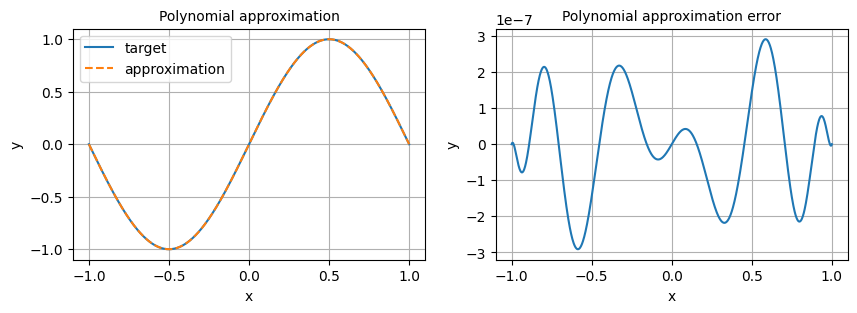

In [4]:
def f2_expand_to_full_polynomial(Tn_partial_sine):
    # f(x) = sin(2*pi*x) / x*(x-0.5)*(x+0.5)
    # f'(x) = sin(2*pi*x) = x*(x-0.5)*(x+0.5)*Tn(x) = (x^3 - 0.25*x)*Tn(x)
    N = len(Tn_partial_sine)
    root = 1
    Tn_sine = np.zeros((N+3,))
    for (power, coefficient) in ((1,-root**2), (3,1)):
        Tn_sine[power:N+power] += Tn_partial_sine*coefficient
    Tn_sine *= -np.pi/(root**2)
    
    x = np.linspace(-1,1,1024)
    y_target = np.sin(np.pi*x)
    y_pred = plot_Tn(Tn_sine, x)
    y_error = y_target-y_pred
    
    fig, axs = plt.subplots(1,2, figsize=(10,3))
    title_size = 10
    ax = axs[0]
    ax.plot(x, y_pred, label="target")
    ax.plot(x, y_target, linestyle="--", label="approximation")
    ax.grid(True)
    ax.set_title("Polynomial approximation", size=title_size)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.legend()

    ax = axs[1]
    ax.plot(x, y_error)
    ax.grid(True)
    ax.set_title("Polynomial approximation error", size=title_size)
    ax.set_xlabel("x")
    ax.set_ylabel("y")

    return Tn_sine

Tn_sine = f2_expand_to_full_polynomial(Tn_partial_sine)

In [5]:
# print polynomial
print([x for x in Tn_partial_sine if np.abs(x) > 1e-4])
print(' + '.join(f"{x:.9f}*x^{i}" for (i,x) in enumerate(Tn_partial_sine) if np.abs(x) > 1e-4))

[0.9999997571463403, -0.6449218592586944, 0.1667099131572423, -0.023664120246180975, 0.0018765462849672444]
0.999999757*x^0 + -0.644921859*x^2 + 0.166709913*x^4 + -0.023664120*x^6 + 0.001876546*x^8
